# Tracking the emergence of computer science topics in papers, grants, and patents

**Abstract**
Ideas flow between universities, industry, and funding agencies through word of mouth, seminars, conferences, publications, new software, new funding, and the media. What is the temporal relationship between these entities? How long does it take for an idea that is popular in scientific research (as seen through mentions in scientific papers) to find technological applications (as seen through mentions in patents)?

In this paper, we select ten emerging trends in computer science as case studies (deep neural networks, long short term memory networks, autoencoders, generative adversarial networks, knowledge graphs, word embeddings, cloud computing, the internet of things, blockchain, and crowdsourcing) and track their frequency in datasets of research paper abstracts, patents, and grants. We calculate the lag between each dataset, finding that for seven of ten trends, patents lag behind papers (median=1.9 years), while for nine of ten trends, grants lag behind papers (median=2.5 years). We also observe that some trends take more than a decade to become popular after they first appear in research papers, and speculate that in these cases, it was necessary to wait for technology to catch up before the idea could be fully developed.



In [1]:
import os
import re
import random
import matplotlib
import sklearn
import scipy
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
import pickle
import time
import csv
import sys
from matplotlib import rc

from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from tqdm import tqdm

In [2]:
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(scipy.__version__)

1.16.5
0.25.2
3.4.0
1.0.2
1.7.1


In [40]:
term_dict = {
    'Deep neural': ['deep neural', 'deep network'],
    'LSTM': ['long short term memory', 'lstm'],
    'GAN': ['generative adversarial'],
    'KG': ['knowledge graph'],
    'Embeddings': ['word embeddings'],
    'Cloud': ['cloud computing', 'cloud service', 'cloud environment'],
    'IoT': ['internet of thing'],
    'Blockchain': ['blockchain', 'blockchains'],
    'Crowdsourcing': ['crowdsourcing', 'crowd sourcing', 'crowdsource', 'crowdsourced'],
    'Autoencoder': ['autoencoder', 'autoencoders'],
    'Semantic segmentation': ['semantic segmentation'],
    'SDN': ['software defined networking', 'sdn'],
    'Massive MIMO': ['massive mimo'],
    'Big data': ['big data']
}




### For each cluster, create a time series of mentions in abstracts over time

We now need to search for the clusters to pull out the frequency of appearance in abstracts over time. For the cluster ["Internet of things", "IoT"], all abstracts that mention **either** term are included (i.e. an abstract that uses "Internet of things" without the abbreviation "IoT" still counts towards the total for that year). We take document frequency, not term frequency, so the number of times the terms are mentioned in each document do not matter, so long as they are mentioned once.

In [5]:
# List all the cluster terms. This will be more than the total number of clusters.
all_cluster_terms = sum([t for t in term_dict.values()],[])

# Get the cluster titles. This is the list of terms in each cluster
cluster_titles = list(term_dict.keys())

years = list(range(2006,2021))

# This is where we will store the data. The columns correspond to clusters, the rows to years
prevalence_array = np.zeros([len(years), len(cluster_titles)])

for i, year in enumerate(tqdm(years)):
    t0 = time.time()
    with open("../../Data/semantic_scholar_cleaned_langdetect/"+str(year)+".txt", "r") as f:
        documents = f.readlines()
        documents = [d.strip() for d in documents] 
        
    vectorizer = CountVectorizer(strip_accents='unicode',
                             ngram_range=(1,4),
                             vocabulary=all_cluster_terms
                            )
    
    vector = vectorizer.fit_transform(documents)
    
    del documents
    
    for j, cluster in enumerate(cluster_titles):
        indices = []
        for term in term_dict[cluster]:
            indices.append(all_cluster_terms.index(term))

            # If there are multiple terms in a cluster, sum the cluster columns together
            summed_column = np.squeeze(np.asarray(vector[:,indices].sum(axis=1).flatten()))
            # Set any element greater than one to one--we're only counting documents here, not 
            # total occurrences
            summed_column[summed_column!=0] = 1

            # This is the total number of occurrences of the cluster per year
            prevalence_array[i, j] = np.sum(summed_column)
    
    
# Save the data
df = pd.DataFrame(data=prevalence_array, index=years, columns=cluster_titles) 
pickle.dump(df, open('cluster_prevalence2/papers.p', 'wb'))

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [57:24<00:00, 229.64s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'cluster_prevalence2/papers.p'

In [29]:
# List all the cluster terms. This will be more than the total number of clusters.
all_cluster_terms = sum([t for t in term_dict.values()],[])

# Get the cluster titles. This is the list of terms in each cluster
cluster_titles = list(term_dict.keys())

years = list(range(2006,2021))

# This is where we will store the data. The columns correspond to clusters, the rows to years
prevalence_array = np.zeros([len(years), len(cluster_titles)])

for i, year in enumerate(tqdm(years)):
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    vectors = []
    files = []
    for m in months:
        filename = str(year)+m
        files.append(filename)

        t0 = time.time()
        with open("../../Data/uspto_cleaned/"+str(filename)+".txt", "r") as f:
            documents = f.readlines()
            documents = [d.strip() for d in documents]

        vectorizer = CountVectorizer(strip_accents='unicode',
                                 ngram_range=(1,4),
                                 vocabulary=all_cluster_terms,
                                )

        vector = vectorizer.fit_transform(documents)

        del documents

        for j, cluster in enumerate(cluster_titles):
            indices = []
            for term in term_dict[cluster]:
                indices.append(all_cluster_terms.index(term))

                # If there are multiple terms in a cluster, sum the cluster columns together
                summed_column = np.squeeze(np.asarray(vector[:,indices].sum(axis=1).flatten()))
                # Set any element greater than one to one--we're only counting documents here, not 
                # total occurrences
                summed_column[summed_column!=0] = 1

                # This is the total number of occurrences of the cluster per year
                prevalence_array[i, j] += np.sum(summed_column)


        del vector 
        
# Save the data
df = pd.DataFrame(data=prevalence_array, index=years, columns=cluster_titles) 
pickle.dump(df, open('cluster_prevalence2/patents.p', 'wb'))

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [2:43:37<00:00, 654.52s/it]


In [41]:
# List all the cluster terms. This will be more than the total number of clusters.
all_cluster_terms = sum([t for t in term_dict.values()],[])

# Get the cluster titles. This is the list of terms in each cluster
cluster_titles = list(term_dict.keys())

years = list(range(2006,2021))

# This is where we will store the data. The columns correspond to clusters, the rows to years
prevalence_array = np.zeros([len(years), len(cluster_titles)])
funding_array = np.zeros([len(years), len(cluster_titles)])
    
for i, year in enumerate(tqdm(years)):
    documents = []
    funds = []
    for funder in ['Direct_For_Computer_&_Info_Scie_&_Enginr', 'Directorate_For_Engineering', 'Direct_For_Mathematical_&_Physical_Scien']:
        with open("../../Data/nsf_cleaned/"+funder+"/"+str(year)+".txt", "r") as f:
            docs = f.readlines()
            docs = [d.strip() for d in docs] 
            funds += [int(d.split('|')[0]) for d in docs]
            documents += [d.split('|')[1] for d in docs]

    vectorizer = CountVectorizer(strip_accents='unicode',
                             ngram_range=(1,4),
                             vocabulary=all_cluster_terms,
                            )

    vector = vectorizer.fit_transform(documents)

    del documents
    funds = np.array(funds)
    # For each cluster
    for j, cluster in enumerate(cluster_titles):
        indices = []
        # Get the vocabulary indices of the terms within that cluster
        for term in term_dict[cluster]:
            indices.append(all_cluster_terms.index(term))   

        # If there are multiple terms in a cluster, sum the cluster columns together
        summed_column = np.squeeze(np.asarray(vector[:,indices].sum(axis=1).flatten()))

        # Set any element greater than one to one--we're only counting documents here, not 
        # total occurrences
        summed_column[summed_column!=0] = 1

        # This is the total number of occurrences of the cluster per year
        prevalence_array[i, j] += np.sum(summed_column)

        # And this is the amount of funding in that year for that cluster
        funding_array[i, j] += np.sum(funds[np.nonzero(summed_column)[0]])

    
# Save the data
df = pd.DataFrame(data=prevalence_array, index=years, columns=cluster_titles) 
pickle.dump(df, open('cluster_prevalence2/nsf.p', 'wb'))

df = pd.DataFrame(data=funding_array, index=years, columns=cluster_titles) 
pickle.dump(df, open('cluster_prevalence2/nsf_funding.p', 'wb'))

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:39<00:00,  6.62s/it]


### Reload the data

The above steps, particularly the patents dataset, will take several hours to complete. Therefore, after each step we save the processed data and then reload it here.

In [59]:
years = list(range(2006,2021))

patents_document_count_per_year = pickle.load(open("../stacked_vectors/uspto_document_count_by_year.p", "rb"))
patents_per_year = pickle.load(open('cluster_prevalence2/patents.p', "rb"))

papers_document_count_per_year = pickle.load(open("../stacked_vectors/semantic_scholar_document_count.p", "rb")).loc[years]
papers_per_year = pickle.load(open('cluster_prevalence2/papers.p', "rb"))

# Remove a known erronous piece of data (paper filed by system in wrong year)
papers_per_year['GAN'][2009]=0

grants_document_count_per_year = pickle.load(open("../stacked_vectors/nsf_document_count.p", "rb")).loc[years]
grants_per_year = pickle.load(open('cluster_prevalence2/nsf.p', "rb"))

grants_funding = pickle.load(open('cluster_prevalence2/nsf_funding.p', "rb"))

terms = ['Deep neural', 'LSTM', 'Autoencoder', 'GAN', 'Embeddings', 'Semantic segmentation', 'IoT', 
         'Crowdsourcing', 'KG', 'Big data', 'Blockchain', 'Cloud', 'SDN', 'Massive MIMO']
titles = ['DNN', 'LSTM', 'Autoencoder', 'GAN', 'Embeddings', 'Semantic segmentation', 'IoT', 'Crowdsourcing', 
          'Knowledge graph', 'Big data', 'Blockchain', 'Cloud computing', 'SDN', 'Massive MIMO']
long_titles = ['Deep neural network', 'Long short-term memory', 'Autoencoder', 'Generative adversarial network', 'Embeddings', 
               'Semantic segmentation', 'Internet of Things', 'Crowdsourcing', 'Knowledge graph', 'Big data',
               'Blockchain', 'Cloud computing', 'Software-defined networking', 'Massive MIMO']

# Earliest mentions of each topic in the papers dataset, which dates from 1981. Earliest mention decided through
# searching for each term in each cluster in the dataset, then manually checking the earliest mentions to ensure 
# that they do actually correspond to the intended topic
earliest_mentions = {'Deep neural': 1992, 
                     'LSTM': 1997, 
                     'Autoencoder': 1990, 
                     'GAN': 2014, 
                     'Embeddings': 2010, 
                     'Semantic segmentation': 1993, 
                     'IoT': 1997, 
                     'Crowdsourcing': 2006,
                     'KG': 1991,
                     'Blockchain': 2011,
                     'Cloud': 1990,
                     'SDN': 2010, 
                     'Massive MIMO': 2011,
                     'Big data': 1996
                    }

In [60]:
papers_per_year[terms]

,Deep neural,LSTM,Autoencoder,GAN,Embeddings,Semantic segmentation,IoT,Crowdsourcing,KG,Big data,Blockchain,Cloud,SDN,Massive MIMO
2006,1.0,7.0,1.0,0.0,0.0,5.0,9.0,1.0,3.0,5.0,0.0,8.0,4.0,0.0
2007,4.0,7.0,2.0,0.0,0.0,8.0,10.0,0.0,4.0,7.0,0.0,0.0,2.0,0.0
2008,6.0,5.0,3.0,0.0,0.0,4.0,31.0,15.0,8.0,4.0,0.0,73.0,2.0,0.0
2009,10.0,14.0,9.0,0.0,0.0,15.0,44.0,43.0,2.0,17.0,0.0,546.0,2.0,0.0
2010,19.0,15.0,8.0,0.0,1.0,19.0,151.0,141.0,13.0,22.0,0.0,1340.0,6.0,0.0
2011,30.0,22.0,13.0,0.0,1.0,20.0,298.0,362.0,5.0,48.0,0.0,2346.0,8.0,1.0
2012,62.0,22.0,24.0,0.0,1.0,41.0,522.0,573.0,18.0,461.0,0.0,3068.0,103.0,16.0
2013,181.0,29.0,48.0,0.0,11.0,39.0,746.0,834.0,51.0,1415.0,3.0,3711.0,326.0,83.0
2014,492.0,56.0,134.0,3.0,61.0,50.0,1236.0,1132.0,74.0,2424.0,12.0,4209.0,768.0,277.0
2015,996.0,240.0,242.0,5.0,191.0,117.0,2099.0,1263.0,130.0,3556.0,41.0,4333.0,1117.0,460.0


In [61]:
patents_per_year[terms]

,Deep neural,LSTM,Autoencoder,GAN,Embeddings,Semantic segmentation,IoT,Crowdsourcing,KG,Big data,Blockchain,Cloud,SDN,Massive MIMO
2006,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,0.0,18.0,13.0,0.0
2007,1.0,0.0,0.0,0.0,0.0,1.0,3.0,6.0,0.0,8.0,0.0,6.0,14.0,0.0
2008,2.0,0.0,0.0,0.0,0.0,2.0,1.0,18.0,0.0,12.0,0.0,297.0,19.0,0.0
2009,6.0,0.0,2.0,0.0,0.0,5.0,0.0,36.0,1.0,6.0,0.0,1333.0,18.0,0.0
2010,1.0,0.0,0.0,0.0,0.0,2.0,9.0,153.0,1.0,10.0,0.0,3274.0,11.0,0.0
2011,6.0,4.0,4.0,0.0,2.0,4.0,49.0,372.0,4.0,33.0,0.0,6637.0,94.0,1.0
2012,16.0,0.0,4.0,0.0,0.0,2.0,117.0,799.0,6.0,105.0,0.0,11488.0,131.0,5.0
2013,76.0,4.0,9.0,0.0,1.0,1.0,200.0,1065.0,34.0,386.0,2.0,14202.0,518.0,51.0
2014,157.0,8.0,10.0,0.0,4.0,4.0,615.0,1238.0,54.0,728.0,10.0,16203.0,933.0,97.0
2015,413.0,81.0,46.0,0.0,13.0,13.0,1749.0,1286.0,77.0,1132.0,82.0,19769.0,1150.0,208.0


In [62]:
grants_per_year[terms]

,Deep neural,LSTM,Autoencoder,GAN,Embeddings,Semantic segmentation,IoT,Crowdsourcing,KG,Big data,Blockchain,Cloud,SDN,Massive MIMO
2006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,32.0,0.0,0.0
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,82.0,6.0,0.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,2.0,29.0,0.0,3.0,0.0,102.0,1.0,0.0
2012,2.0,0.0,0.0,0.0,0.0,0.0,1.0,39.0,0.0,51.0,0.0,112.0,15.0,0.0
2013,2.0,0.0,1.0,0.0,0.0,2.0,7.0,35.0,0.0,183.0,0.0,108.0,37.0,1.0
2014,4.0,0.0,0.0,0.0,0.0,0.0,17.0,41.0,1.0,229.0,0.0,133.0,53.0,3.0
2015,9.0,0.0,0.0,0.0,0.0,3.0,61.0,64.0,3.0,331.0,2.0,131.0,49.0,5.0


In [63]:
papers_s

,multilingual,bottleneck,feature,improving,asr,performance,code,switched,speech,resourced,...,interface definition language idl,mu double,spl mu double,block motion compensation,ttcn,layout tool,1999a,verification reactive system,embedded bit stream,event list
2006,274,896,14682,3558,194,31883,7086,747,2746,6,...,1,0,0,9,2,3,5,5,7,2
2007,254,906,16267,4026,250,34984,7489,758,3110,9,...,1,0,0,3,6,1,2,3,3,0
2008,289,1038,17245,4404,253,36604,7491,721,3043,17,...,3,0,0,5,6,5,5,3,3,4
2009,268,1057,19285,4864,232,40549,7967,817,3021,26,...,0,0,0,4,0,2,8,5,5,1
2010,311,1163,20519,5193,271,42465,8020,740,3350,44,...,0,0,0,9,1,0,3,3,2,3
2011,319,1291,22670,5855,290,48385,8516,854,3393,46,...,4,0,0,7,0,7,2,5,1,5
2012,360,1291,24374,6453,334,52589,9467,904,3493,88,...,1,0,0,3,2,4,0,2,5,4
2013,337,1461,26643,6989,307,56311,9795,994,3705,51,...,0,0,0,6,2,6,1,3,1,5
2014,406,1526,29030,7437,351,59059,10127,981,3738,101,...,0,0,0,4,0,3,2,1,2,3
2015,391,1643,31110,7898,366,63080,10255,1010,4039,65,...,0,0,0,7,2,5,1,2,1,4


### Calculate funding per cluster and display

We use a latex format here so it can be copied and pasted into the paper as is.

In [64]:
print('Topic & Total funding (million $) \\\\ \\hline')
for i, term in enumerate(terms):
    print(titles[i], '&', np.round(grants_funding[term].sum()/1000000,1), '\\\\ \\hline')

Topic & Total funding (million $) \\ \hline
DNN & 173.0 \\ \hline
LSTM & 8.9 \\ \hline
Autoencoder & 8.6 \\ \hline
GAN & 26.2 \\ \hline
Embeddings & 4.5 \\ \hline
Semantic segmentation & 6.0 \\ \hline
IoT & 299.4 \\ \hline
Crowdsourcing & 195.4 \\ \hline
Knowledge graph & 20.9 \\ \hline
Big data & 1212.0 \\ \hline
Blockchain & 31.3 \\ \hline
Cloud computing & 791.6 \\ \hline
SDN & 179.1 \\ \hline
Massive MIMO & 44.9 \\ \hline


### Plot total documents per year 

This helps illustrate the challenges of the patents dataset and the difficulty of using patents from the 2019-2020 period.


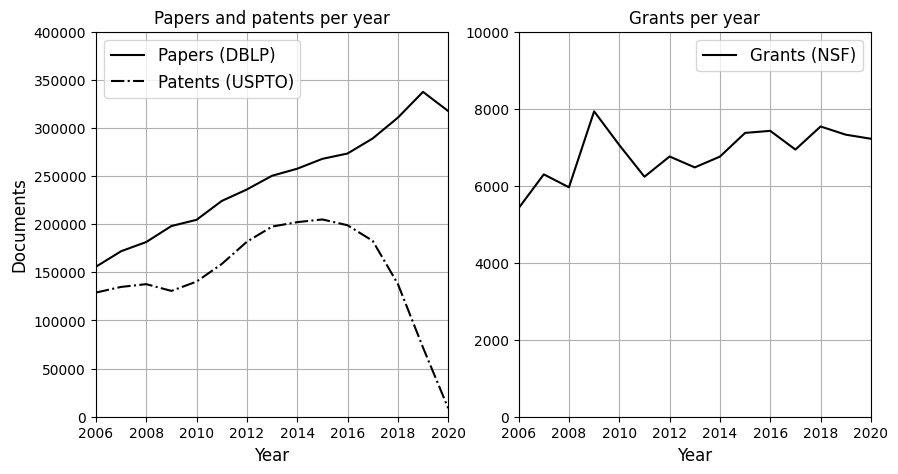

In [65]:
fig = plt.figure(figsize=(10,5))
ax1=plt.subplot(121)
ax1.set_title('Papers and patents per year', fontsize=12)

ax1.plot(years, papers_document_count_per_year.loc[range(2006,2021)], 'k', label='Papers (DBLP)')
ax1.plot(years, patents_document_count_per_year, 'k', linestyle= '-.', label='Patents (USPTO)')
ax1.grid()


ax1.set_xlim([2006,2020])
ax1.set_ylabel('Documents', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylim([0,400000])
ax1.legend(fontsize=12)

ax2=plt.subplot(122)
ax2.set_title('Grants per year', fontsize=12)

ax2.plot(years, grants_document_count_per_year, 'k',  label='Grants (NSF)')
ax2.grid()


ax2.set_xlim([2006,2020])
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylim([0,10000])
ax2.legend(fontsize=12)

plt.show()
#fig.savefig('images/dataset_size.png', dpi=600)

### Calculate peaks, first year above 20 mentions, and first appearance in each dataset

In [66]:
def smooth(df):
    n = 3
    return df.rolling(n).sum().divide(n).shift(-1).drop(2006).drop(2020)
    
def smooth_patents(df):
    n = 3
    return df.rolling(n).sum().divide(n).shift(-1).drop(2006).drop(2018)


smoothed_papers = smooth(papers_per_year)
smoothed_patents = smooth(patents_per_year)
smoothed_grants = smooth(grants_per_year)

print('Topic & \\multicolumn{3}{c||}{Papers} & \\multicolumn{3}{c||}{Patents} &\\multicolumn{3}{c|}{Grants} \\\\ \\cline{2-10}')
print('& $\\geq$1 & $\\geq$20 & Peak & $\\geq$1 & $\\geq$20 & Peak & $\\geq$1 & $\\geq$3 & Peak \\\\ \\hline')


n = 19
for i, term in enumerate(terms):
    grantsgeq = 'N/A'
    try:
        grantsgeq = smoothed_grants[smoothed_grants[term].gt(2)].index[0]
    except: 
        pass
    
     
    print(titles[i], '&', 
          earliest_mentions[term], '&',
          smoothed_papers[smoothed_papers[term].gt(n)].index[0], '&',
          smoothed_papers[term].idxmax(), '&',
          patents_per_year[patents_per_year[term].gt(0)].index[0], '&',
          smoothed_patents[smoothed_patents[term].gt(n)].index[0], '&',
          smoothed_patents[term].idxmax(), '&',   
          grants_per_year[grants_per_year[term].gt(0)].index[0], '&', 
          grantsgeq, '&',
          smoothed_grants[term].idxmax(), '\\\\'
         )

Topic & \multicolumn{3}{c||}{Papers} & \multicolumn{3}{c||}{Patents} &\multicolumn{3}{c|}{Grants} \\ \cline{2-10}
& $\geq$1 & $\geq$20 & Peak & $\geq$1 & $\geq$20 & Peak & $\geq$1 & $\geq$3 & Peak \\ \hline
DNN & 1992 & 2010 & 2019 & 2007 & 2012 & 2018 & 2012 & 2013 & 2019 \\
LSTM & 1997 & 2011 & 2019 & 2011 & 2014 & 2018 & 2017 & 2017 & 2019 \\
Autoencoder & 1990 & 2012 & 2019 & 2009 & 2014 & 2018 & 2013 & 2018 & 2019 \\
GAN & 2014 & 2015 & 2019 & 2016 & 2016 & 2018 & 2017 & 2017 & 2019 \\
Embeddings & 2010 & 2013 & 2019 & 2011 & 2016 & 2017 & 2016 & 2018 & 2018 \\
Semantic segmentation & 1993 & 2011 & 2019 & 2006 & 2016 & 2018 & 2013 & 2015 & 2016 \\
IoT & 1997 & 2008 & 2019 & 2007 & 2010 & 2017 & 2008 & 2012 & 2019 \\
Crowdsourcing & 2006 & 2008 & 2017 & 2007 & 2008 & 2016 & 2009 & 2009 & 2016 \\
Knowledge graph & 1991 & 2012 & 2019 & 2009 & 2013 & 2017 & 2014 & 2016 & 2019 \\
Big data & 1996 & 2010 & 2018 & 2006 & 2011 & 2016 & 2009 & 2011 & 2016 \\
Blockchain & 2011 & 2015 & 2019 

## Calculating lag of papers, patents, and grants

This cell demonstrates the lag calculation. In order to calculate lag, we repeatedly shift the two time series against each other, calculating error at each point. When lowest error is reached, we interpolate to find the lag.

C:\Users\emmat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


1.7800000000000034


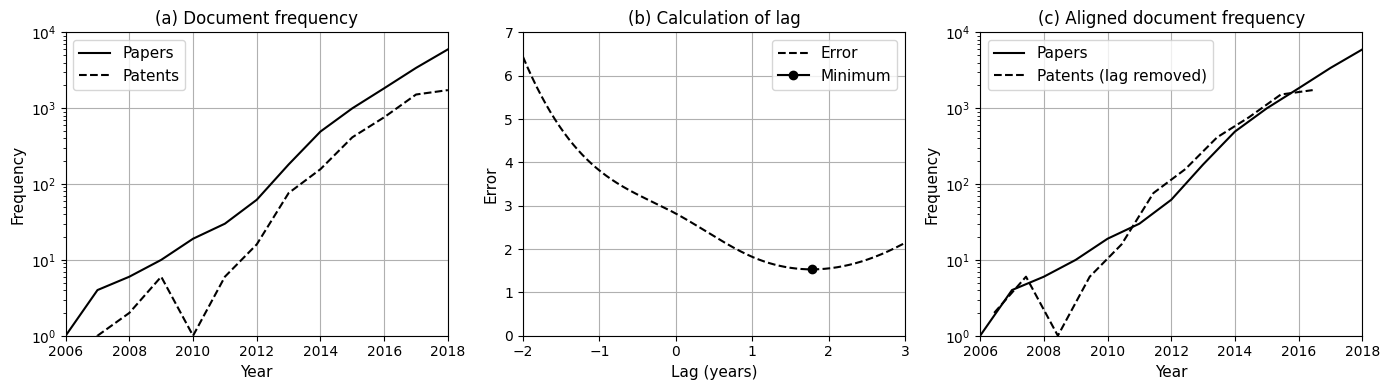

In [67]:
def logarithmic(df):
    a = np.log(df)
    a.replace([np.inf, -np.inf], 0, inplace=True)
    return a

def shift(series1, series2, n):
    # Shift series 2 relative to series 1. Remove the NaN rows from both.
    series2 = series2.shift(n)
    indices = []
    
    # Remove rows with NaNs
    nan_rows = list(series2[series2.isna()].index)
    series2 = series2.drop(nan_rows)
    for nan_row in nan_rows:
        try:
            series1 = series1.drop(nan_row)
        except:
            pass
    
    # Check both series are the same length, and if not, trim
    series2 = series2.drop(list(set(series2.index)-set(series1.index)))
    return series1, series2

log_papers = logarithmic(papers_per_year)
log_patents = logarithmic(patents_per_year)


fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(14)

term = 'Deep neural'

years = list(range(2006,2019))
xaxis = list(range(0,13))
y_papers = list(papers_per_year[term].loc[years])
y_patents = list(patents_per_year[term].loc[years])


# Figure 1: the base situation
axes[0].semilogy(years, y_papers, linestyle='-', color='k', label='Papers') 
axes[0].semilogy(years, y_patents, linestyle='--', color='k', label='Patents')   
axes[0].set_title('(a) Document frequency')
axes[0].grid(True)
axes[0].set_xlim(2006,2018)
axes[0].legend(fontsize=11)
axes[0].set_ylim(1,10000)
axes[0].set_xlabel('Year', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)

# Figure 2: Lag calculation
x = np.arange(-2, 4)
y = []
for n in x:
    a, b = shift(log_patents[term], log_papers[term], n)
    y.append(mean_squared_error(a, b))
    
f = interp1d(x, y, kind='cubic')
xnew = np.arange(-2, 3,0.01)
print(xnew[f(xnew).argmin()])

axes[1].plot(xnew, f(xnew), '--', color='k', label='Error')
axes[1].plot(xnew[f(xnew).argmin()], min(f(xnew)), marker='o', color='k', label='Minimum')
axes[1].set_xlabel('Lag (years)', fontsize=11)
axes[1].set_ylabel('Error', fontsize=11)
axes[1].set_ylim([0,7])
axes[1].grid(True)
axes[1].set_xlim(-2,3)
axes[1].legend(fontsize=11)
axes[1].set_title('(b) Calculation of lag')

# Figure 3: shifted figure 1
y_patents = list(patents_per_year[term].loc[years])
axes[2].semilogy(years, y_papers, linestyle='-', color='k', label='Papers') 
axes[2].semilogy(np.array(years[2:])-1.56, y_patents[2:], linestyle='--', color='k', label='Patents (lag removed)')   
axes[2].set_title('(c) Aligned document frequency')
axes[2].grid(True)
axes[2].set_xlim(2006,2018)
axes[2].legend(fontsize=11)
axes[2].set_ylim(1,10000)
axes[2].set_xlabel('Year', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
plt.tight_layout()
plt.show()
#fig.savefig('images/lagcalculation.png',  dpi=600)

### Now calculate lag for all terms

In [68]:
log_papers = logarithmic(1 + papers_per_year)
log_patents = logarithmic(1 + patents_per_year.loc[list(range(2006, 2019))])
log_grants = logarithmic(1 + 20*grants_per_year)

all_patent_lag = []
all_grant_lag = []
year_shifts = np.arange(-4, 4)
for i, term in enumerate(terms):
    
    # For patents
    mse = []
    for year_shift in year_shifts:
        a, b = shift(log_patents[term], log_papers[term], year_shift)
        mse.append(mean_squared_error(a, b))
    
    # Calculate the lag at minimum error
    f = interp1d(year_shifts, mse, kind='cubic')
    xnew = np.arange(-4, 3,0.01)
    patent_lag = xnew[f(xnew).argmin()]
    all_patent_lag.append(patent_lag+0.5)
    
    # For grants
    mse = []
    for year_shift in year_shifts:
        a, b = shift(log_grants[term], log_papers[term], year_shift)
        mse.append(mean_squared_error(a, b))
    
    # Calculate the lag at minimum error
    f = interp1d(year_shifts, mse, kind='cubic')
    xnew = np.arange(-4, 3,0.01)
    grant_lag = xnew[f(xnew).argmin()]
    all_grant_lag.append(grant_lag)
    
    # 0.5 added to lag as estimate of difference between date published/date registered
    print(titles[i], '&', np.round(patent_lag+0.5,1), '&', np.round(grant_lag, 1), '\\\\ \\hline')
     

DNN & 2.0 & 2.5 \\ \hline
LSTM & 2.4 & 3.0 \\ \hline
Autoencoder & 3.2 & 3.0 \\ \hline
GAN & 1.7 & 1.5 \\ \hline
Embeddings & 2.9 & 3.0 \\ \hline
Semantic segmentation & 3.3 & 3.0 \\ \hline
IoT & 2.8 & 3.0 \\ \hline
Crowdsourcing & -0.1 & 0.7 \\ \hline
Knowledge graph & 1.8 & 2.5 \\ \hline
Big data & 1.5 & -0.1 \\ \hline
Blockchain & 0.3 & 1.8 \\ \hline
Cloud computing & 0.2 & -0.1 \\ \hline
SDN & -0.5 & -0.4 \\ \hline
Massive MIMO & 1.1 & 1.2 \\ \hline


In [69]:
print('Median')
print('Papers-patents', np.round(np.median(all_patent_lag),2))
print('Papers-grants', np.round(np.median(all_grant_lag),2))
print()
print('Mean')
print('Papers-patents', np.round(np.mean(all_patent_lag),2))
print('Papers-grants', np.round(np.mean(all_grant_lag),2))
print()
print('Standard deviation')
print('Papers-patents', np.round(np.std(all_patent_lag),2))
print('Papers-grants', np.round(np.std(all_grant_lag),2))

Median
Papers-patents 1.73
Papers-grants 2.15

Mean
Papers-patents 1.62
Papers-grants 1.76

Standard deviation
Papers-patents 1.21
Papers-grants 1.24


### Plot on graphs, grouped by behaviour 

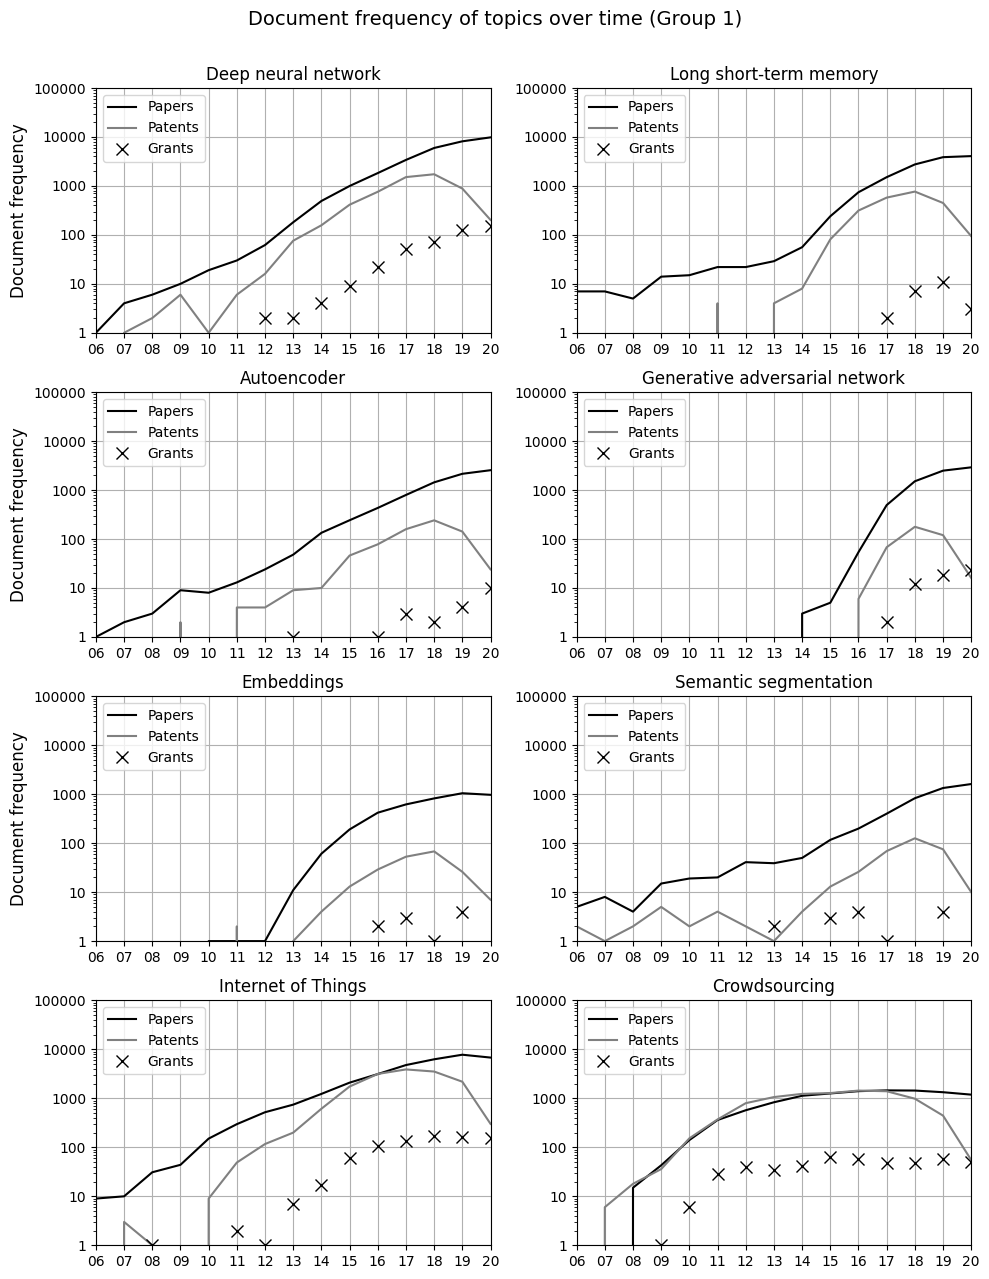

In [72]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.set_figheight(13)
fig.set_figwidth(10)

x = list(range(2006,2021))
ticklabels = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
for i, term in enumerate(terms[0:8]):
    row = int(np.floor(i/2))
    col = i%2
    y_grants = list(grants_per_year[term].loc[x])
    y_papers = list(papers_per_year[term].loc[x])
    y_patents = list(patents_per_year[term].loc[x])

    df = pd.DataFrame({'year':list(range(0,len(x))), 'Grants':y_grants, 'Papers':y_papers, 'Patents':y_patents})

    axes[row,col].semilogy(list(df['year']),list(df['Papers']), label='Papers', color='k')
    axes[row,col].semilogy(list(df['year']),list(df['Patents']), label='Patents', color='grey')
    axes[row,col].semilogy(list(df['year']),list(df['Grants']), label='Grants', color='k', marker='x', markersize=8, linestyle='None')

    axes[row, col].set_title(long_titles[i])
    axes[row,col].set_ylim(1,100000)
    axes[row, col].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    axes[row,col].yaxis.set_minor_formatter(NullFormatter())
    axes[row,col].grid(True)
    axes[row,col].set_xlim(0,14)
    axes[row,col].set_xticks(np.arange(0,15))
    axes[row,col].xaxis.set_ticklabels(ticklabels, rotation=0)
    axes[row,col].legend(loc=2)
    
    if i < 4:
        axes[row,col].set_xlabel("")
        
    #if i%2 == 0:
    #    axes[row,col].set_ylabel("Documents")
axes[0,0].set_ylabel('Document frequency', fontsize=12)
axes[1,0].set_ylabel('Document frequency', fontsize=12)
axes[2,0].set_ylabel('Document frequency', fontsize=12)
plt.suptitle('Document frequency of topics over time (Group 1)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

plt.show()


fig.savefig('images/topics_group_1.png', dpi=600)

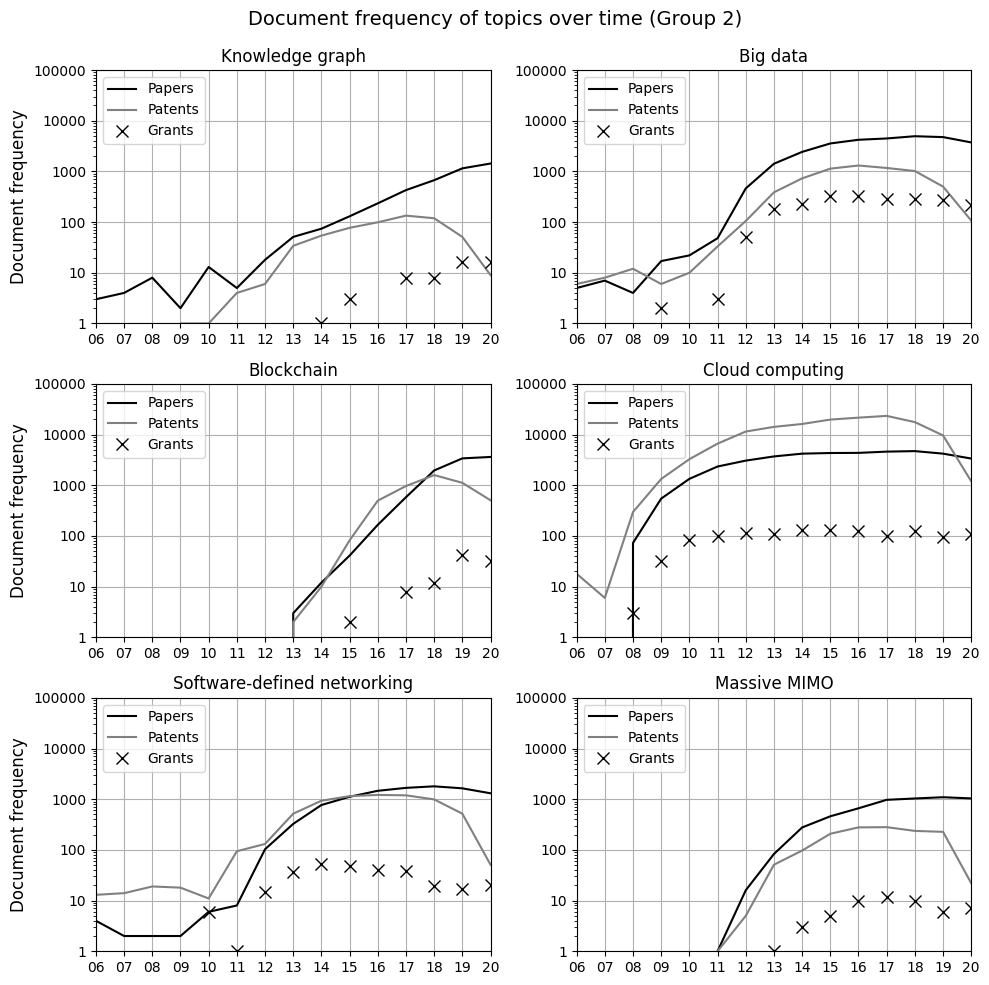

In [73]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(10)

x = list(range(2006,2021))
ticklabels = ['06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
for i, term in enumerate(terms[8:]):
    row = int(np.floor(i/2))
    col = i%2
    y_grants = list(grants_per_year[term].loc[x])
    y_papers = list(papers_per_year[term].loc[x])
    y_patents = list(patents_per_year[term].loc[x])

    df = pd.DataFrame({'year':list(range(0,len(x))), 'Grants':y_grants, 'Papers':y_papers, 'Patents':y_patents})
        
    axes[row,col].semilogy(list(df['year']),list(df['Papers']), label='Papers', color='k')
    axes[row,col].semilogy(list(df['year']),list(df['Patents']), label='Patents', color='grey')
    axes[row,col].semilogy(list(df['year']),list(df['Grants']), label='Grants', color='k', marker='x', markersize=8, linestyle='None')

    axes[row, col].set_title(long_titles[i+8])
    axes[row,col].set_ylim(1,100000)
    axes[row, col].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    axes[row,col].yaxis.set_minor_formatter(NullFormatter())
    axes[row,col].grid(True)
    axes[row,col].set_xlim(0,14)
    axes[row,col].set_xticks(np.arange(0,15))
    axes[row,col].xaxis.set_ticklabels(ticklabels, rotation=0)
    axes[row,col].legend(loc=2)
    
    if i < 4:
        axes[row,col].set_xlabel("")
        
    #if i%2 == 0:
    #    axes[row,col].set_ylabel("Documents")
axes[0,0].set_ylabel('Document frequency', fontsize=12)
axes[1,0].set_ylabel('Document frequency', fontsize=12)
axes[2,0].set_ylabel('Document frequency', fontsize=12)
plt.suptitle('Document frequency of topics over time (Group 2)', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

plt.show()


fig.savefig('images/topics_group_2.png', dpi=600)